In [1]:
%load_ext autoreload
%autoreload 2

In [132]:
import numpy as np
import xarray as xr
import wmt_bgc.basic as wmt
from xgcm import Grid
import matplotlib.pyplot as plt

In [31]:
# Load some T and S data, and grid data
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'
pp = 'ocean_annual_z'
localdir = '/ts/annual/5yr/'
filename = pp+'.2013-2017.*.nc'
ds = xr.open_mfdataset(rootdir+pp+localdir+filename).isel(time=0)
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')

In [119]:
# Calculate some derived variables
ds['g'] = wmt.sigmantr_mjd05(ds['so'],ds['thetao'])
ds['p'] = wmt.gsw_p_from_z(-ds['z_l'],grid['geolat'])
ds['alpha'] = wmt.gsw_alpha(ds['so'],ds['thetao'],ds['p'])
ds['beta'] = wmt.gsw_beta(ds['so'],ds['thetao'],ds['p'])
ds['rhoinsitu'] = wmt.gsw_rho(ds['so'],ds['thetao'],ds['p'])
# Vertical grid spacing
ds['dzt'] = xr.DataArray(data=ds['z_i'].diff('z_i').values,
                         coords={'z_l': ds['z_l']},
                         dims=('z_l'))
ds = xr.merge([ds,grid])

In [120]:
# Build xgcm grid object
# (see https://mom6-analysiscookbook.readthedocs.io/en/latest/01c_getting_started.html#building-a-xgcm-grid-object)

# Fill in nans with zeros
ds['dxt'] = ds['dxt'].fillna(0.)
ds['dyt'] = ds['dyt'].fillna(0.)
ds['dzt'] = ds['dzt'].fillna(0.)
ds['areacello'] = ds['areacello'].fillna(0.)
ds['volcello'] = ds['volcello'].fillna(0.)

metrics = {
    ('X',): ['dxt','dxCu','dxCv'], # X distances
    ('Y',): ['dyt','dyCu','dyCv'], # Y distances
    ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    ('X', 'Y', 'Z'): ['volcello'], # Volumes
}

coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'z_l', 'outer': 'z_i'} }

xgrid = Grid(ds, coords=coords, metrics=metrics, periodic=['X'])

In [121]:
# Calculate gradients in T, S, and gamma
# (first interpolate to edge points to that 
# resultant gradient is in the center)
# Horizontal
Txq = xgrid.interp(ds['thetao'],'X')
dTdx = xgrid.derivative(Txq, 'X')
Tyq = xgrid.interp(ds['thetao'],'Y',boundary='fill')
dTdy = xgrid.derivative(Tyq, 'Y',boundary='fill')
Sxq = xgrid.interp(ds['so'],'X')
dSdx = xgrid.derivative(Sxq, 'X')
Syq = xgrid.interp(ds['so'],'Y',boundary='fill')
dSdy = xgrid.derivative(Syq, 'Y',boundary='fill')
gxq = xgrid.interp(ds['g'],'X')
dgdx = xgrid.derivative(gxq, 'X')
gyq = xgrid.interp(ds['g'],'Y',boundary='fill')
dgdy = xgrid.derivative(gyq, 'Y',boundary='fill')
# Vertical
T_zi = xgrid.interp(ds['thetao'],'Z',boundary='extrapolate')
dTdz = xgrid.derivative(T_zi, 'Z')
S_zi = xgrid.interp(ds['so'],'Z',boundary='extrapolate')
dSdz = xgrid.derivative(S_zi, 'Z')
g_zi = xgrid.interp(ds['g'],'Z',boundary='extrapolate')
dgdz = xgrid.derivative(g_zi, 'Z')

In [122]:
# Calculate derivative of locally referenced potential density
rho = ds['rhoinsitu']
alpha = ds['alpha']
beta = ds['beta']

drdx = rho*(-alpha*dTdx + beta*dSdx)
drdy = rho*(-alpha*dTdy + beta*dSdy)
drdz = rho*(-alpha*dTdz + beta*dSdz)

In [123]:
# Calculate absolute magnitude of gradients
absgradr = xr.ufuncs.sqrt(xr.ufuncs.square(drdx)+
                          xr.ufuncs.square(drdy)+
                          xr.ufuncs.square(drdz))
absgradg = xr.ufuncs.sqrt(xr.ufuncs.square(dgdx)+
                          xr.ufuncs.square(dgdy)+
                          xr.ufuncs.square(dgdz))

In [124]:
# Calculate b as ratio
b = absgradg/absgradr

In [125]:
b.load();

<ipython-input-142-14b87ebfa22c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),


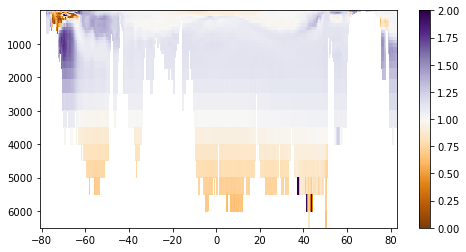

In [142]:
select = {'xh':-180}
fig,ax = plt.subplots(figsize=(8,4))
im = ax.pcolormesh(ds['geolat'].sel(select,method='nearest'),
                   ds['z_l'],
                   b.sel(select,method='nearest'),
                   vmin=0,vmax=2,cmap='PuOr')
ax.invert_yaxis()
plt.colorbar(im,ax=ax)

In [137]:
b

<xarray.DataArray (z_l: 35, yh: 1080, xh: 1440)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
    time     object 2013-07-02 12:00:00